In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

## Data with Increasing Variance

I want to create a dataset where the variance/standard deviation increases over time, violating one of the key assumptions of Ordinary Least Squares and see what results follow.

## Generating Data

We'll consider a dataset with a predictor variable x and target variable y. I will generate data with x values uniformly distributed between $x = 0$ and $x = 100$. The twist is that when I add in my noise to generate y, I will make the variance increase proportional to our x values. 

I will also assume a true underlying slope of $\beta = 1$

In [2]:
n = 101 #number of x values
x = np.linspace(0, 100, n)

Now I will generate several y values for each x coordinate, making the variance proportional to the x value:

In [3]:
#number of y values per x value
y_gen = 5

#allow for repeated x values
x_array_list = [np.repeat(x[i], y_gen) for i in range(n)] 
x_graph = np.concatenate(x_array_list)

y_array_list = []

#generate y values
for i in range(10):
    y = np.concatenate(x_array_list[i*10:(i+1)*10]) + np.random.normal(0, (i+1)*2, y_gen*10)
    y_array_list.append(y)
    
y = np.concatenate(y_array_list)
x_graph = np.delete(x_graph, np.where(x_graph == n-1)) #revoves the edge x value so that y matches shape

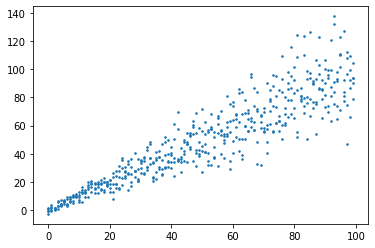

In [4]:
plt.scatter(x_graph, y, s = 2.5)
plt.show()

What we can see is an expanding effect as x increases, which is very natural to think of as variation increasing over time in a process. I have staggered the increase in variance to occur at regular interavls. From $x=0$ to $x=10$ there are points with $\sigma = 2$, From $x=10$ to $x=20$ there are 30 points with $\sigma = 4$, etc.

## Fitting OLS Models

Now I will fit an OLS to our dataset, temporarily ignoring the failure of homoscedasticity

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

x_graph = x_graph.reshape(-1, 1)
y = y.reshape(-1, 1)

lin_reg = LinearRegression()
full_reg = lin_reg.fit(x_graph, y)

#store model statistics for later
full_coef = full_reg.coef_[0][0]
full_mse = mean_squared_error(y, full_reg.predict(x_graph))

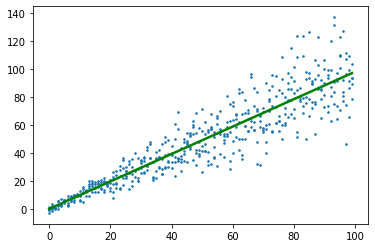

In [6]:
plt.plot(x_graph, full_reg.predict(x_graph), linewidth = 2.5, color = 'green', label = 'regression')
plt.scatter(x_graph, y, s = 2.5)
plt.show()

Now for each range of values where we do have constant variance, I will fit an OLS model:

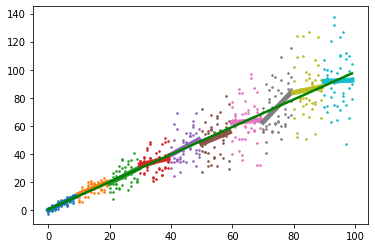

In [7]:
#lists to store model statistics to examine later
coef_partition = [] 
mse_partition = []

for i in range(10):
    #get partition indices
    low_index = i*10*y_gen
    high_index = (i+1)*10*y_gen
    
    x_partition = x_graph[low_index:high_index].reshape(-1, 1)
    y_partition = y[low_index:high_index].reshape(-1, 1)
    
    partition_reg = lin_reg.fit(x_partition, y_partition)
    
    #store model statistics to examine later
    coef_partition.append(partition_reg.coef_[0][0])
    mse_partition.append(mean_squared_error(y_partition, partition_reg.predict(x_partition)))
    
    plt.plot(x_partition, full_reg.predict(x_partition), linewidth = 5)
    plt.scatter(x_partition, y_partition, s = 2.5)

#include full regression
full_reg = lin_reg.fit(x_graph.reshape(-1, 1), y.reshape(-1, 1))
plt.plot(x_graph, full_reg.predict(x_graph.reshape(-1, 1)), linewidth = 2.5, color = 'green', label = 'regression')
plt.show()

What we see is that when taken as individual pieces with all of the assumptions of linear regression actually met that we return a very different set of coefficients than the faulty OLS on the entire dataset. We can look at these coefficients directly:

In [8]:
import pandas as pd

d = {'X Domain':[(10*i, 10*(i+1)) for i in range(10)],
     'Coefficient':coef_partition,
     'Standard Deviation':range(2, 21, 2),
     'MSE':mse_partition}

partition_df = pd.DataFrame(d)

In [9]:
partition_df

,X Domain,Coefficient,Standard Deviation,MSE
0,"(0, 10)",1.114554,2,2.937880
1,"(10, 20)",0.932616,4,9.288363
2,"(20, 30)",1.128157,6,39.867485
3,"(30, 40)",0.484768,8,54.831737
4,"(40, 50)",1.187752,10,100.718019
5,"(50, 60)",0.910171,12,150.191281
6,"(60, 70)",0.217545,14,219.065430
7,"(70, 80)",2.313364,16,213.556775
8,"(80, 90)",0.471846,18,315.521508
9,"(90, 100)",0.085981,20,336.914376


In [10]:
print('Combined Partition MSE =', partition_df['MSE'].sum())
print('Average Coefficient Estimate =', partition_df['Coefficient'].mean())

Combined Partition MSE = 1442.8928537524773
Average Coefficient Estimate = 0.8846753193206907


In [11]:
print('Full MSE =', full_mse)
print('Full Coefficient Estimate', full_coef)

Full MSE = 148.86065570661972
Full Coefficient Estimate 0.9786826280698403


## Interpretation

It appears that we have a pretty counterintuitive result. It appears that OLS run on the entire dataset is working better at predicting, but how can this be when we generated data that violates our assumptions!? Let's take a closer look at how this would actually be represented in a real world setting

Imagine that this model is designed to predict the price of some commodity, generating a report on a monthly basis (our partitions). We dedcide to use a linear regression to make our predictive model based on our scatterplot of the data, not realizing that we have increasing variance. 

For the first few months everything seems fine. We have a relatively low MSE, and our coefficients seem to be relatively stable. But towards the end of the year, something is clearly wrong. Sometimes our model is predicting widely varying coefficient values, yet somehow still has a low MSE.

Our model actually does a great job of capturing the general long term trend, but because we used linear regression in a situation without homoscedasticity, it is unable to capture short term trends in our data. Put another way, OLS always provides an unbiased estimator for $\beta$, but takes more data to converge when we have higher variance.

In the long term, our violation of the homoscedasticity doesn't drastically change our estimate of our coefficient. But in a real world situation, we almost always need to make a prediction on a recurring basis with a timeframe that is small relative to our dataset. If we make the mistake of applying the wrong method and training our data on a short dataframe, we will have widely diverging predictions from reality.